In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import matplotlib
import random
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")
%matplotlib notebook
%matplotlib notebook

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<IPython.core.display.Javascript object>


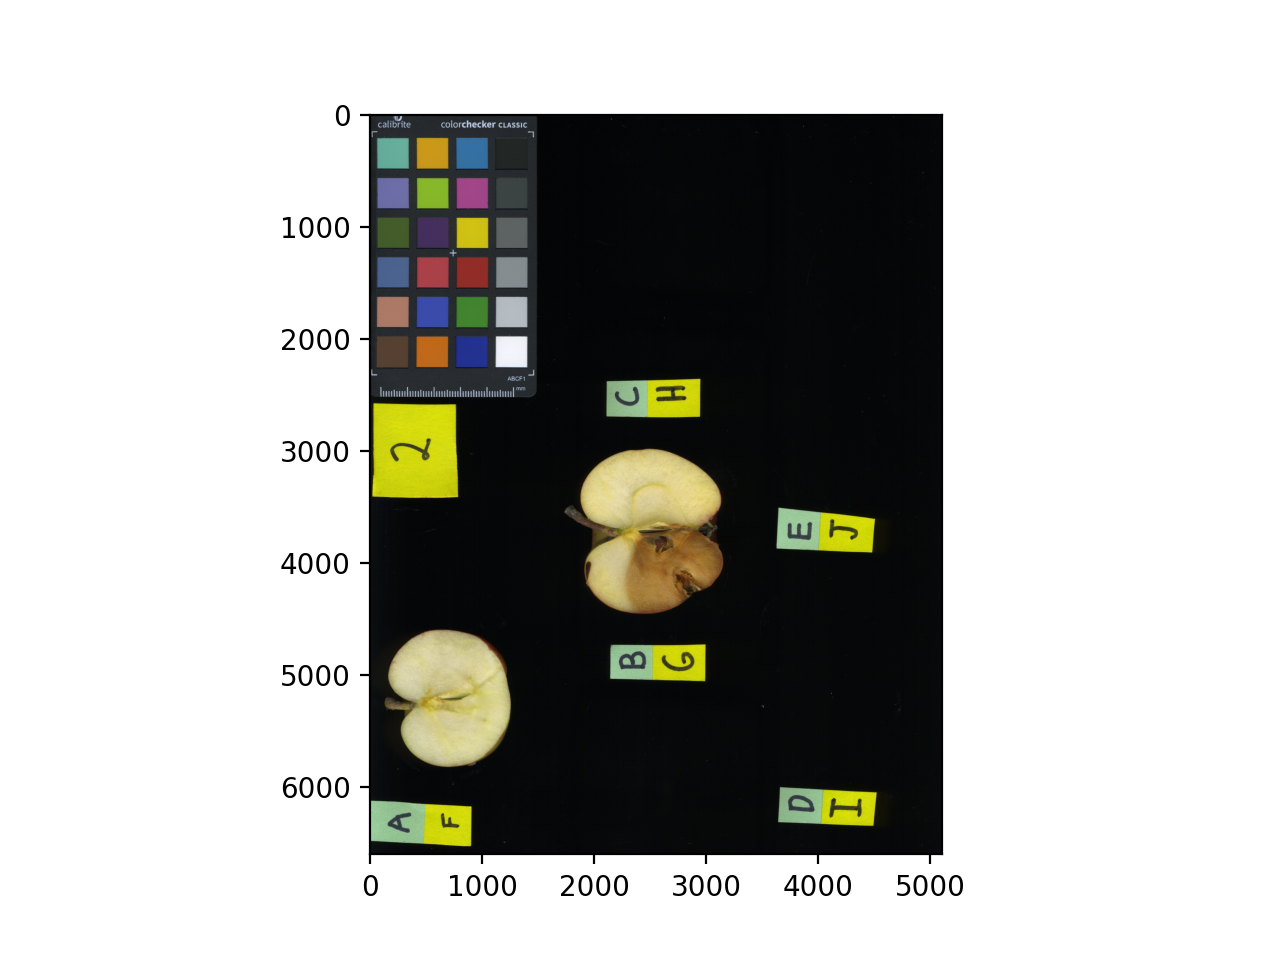

In [6]:
im = cv.imread("/Users/quino070/AppleScans/Fruit/1022-15_R1_S2.jpeg")
#im = cv.imread("/Users/quino070/AppleScans/Leaf/L_1022-49_R1_S001.jpg")


im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
# #adding border to fix leaves too close to the edge
# im = cv.copyMakeBorder(im, 100, 100, 100, 100,
#                                     cv.BORDER_CONSTANT, value=(255, 255, 255)) 
plt.figure()
plt.imshow(im)

In [7]:
# Segment using text prompt
inputs = processor(images=im, text="stem", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")

Found 2 objects


<IPython.core.display.Javascript object>


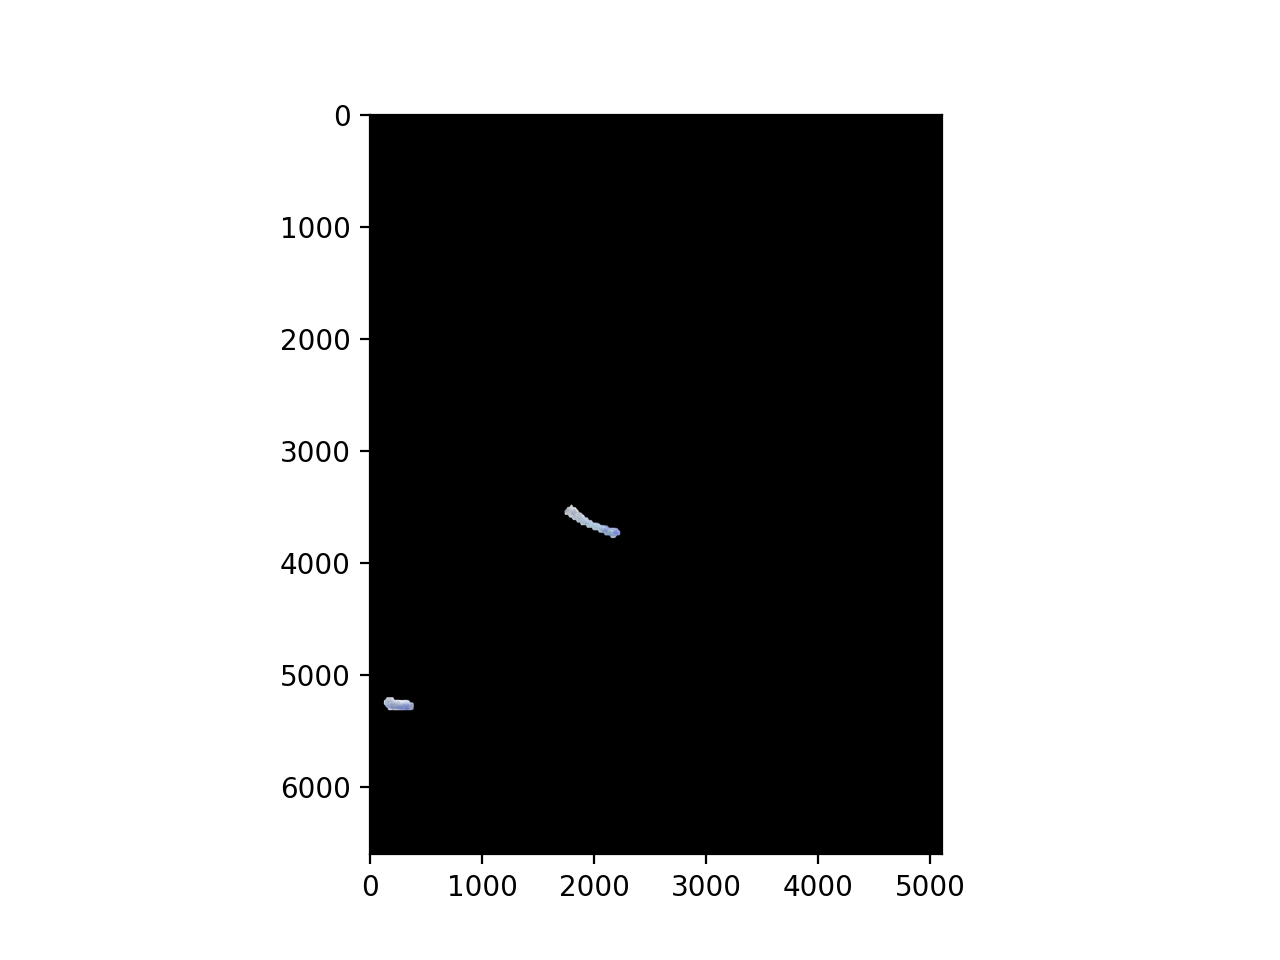

In [8]:
masks = results["masks"]  # list or tensor of shape (N, H, W)

# Stack and combine (logical OR across objects)
if isinstance(masks, list):
    masks_tensor = torch.stack(masks)
else:
    masks_tensor = masks

combined_mask = masks_tensor.any(dim=0).cpu().numpy().astype(np.uint8) * 255
    
image_np = np.array(im)
masked_im = image_np * combined_mask[..., None]                                                             

plt.figure()
plt.imshow(masked_im)

In [5]:
#filter out incorrect masks
filtered_mask_ids = []
for idx, mask in enumerate(masks):
    if np.array(mask.sum() <=70000):
        filtered_mask_ids.append(idx)
    
masks = masks[filtered_mask_ids]
result_boxes = results["boxes"]
result_boxes = result_boxes[filtered_mask_ids]

In [6]:
#Extract stem lengths and coordinates to draw later
stem_lengths = []
boxes = []
for box in result_boxes:
    x0,y0,x1,y1 = np.array(box).astype(int)
    #cv.rectangle(masked_image, (x0, y0), (x1, y1), (255, 0, 0), 20)
    coords = [x0,y0,x1,y1]
    h = x1-x0
    stem_lengths.append(h)
    boxes.append(coords)

<IPython.core.display.Javascript object>


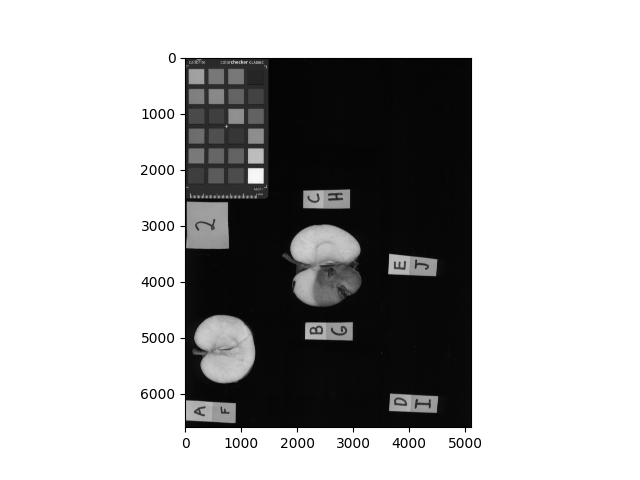

In [7]:
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray, cmap="gray")

<IPython.core.display.Javascript object>


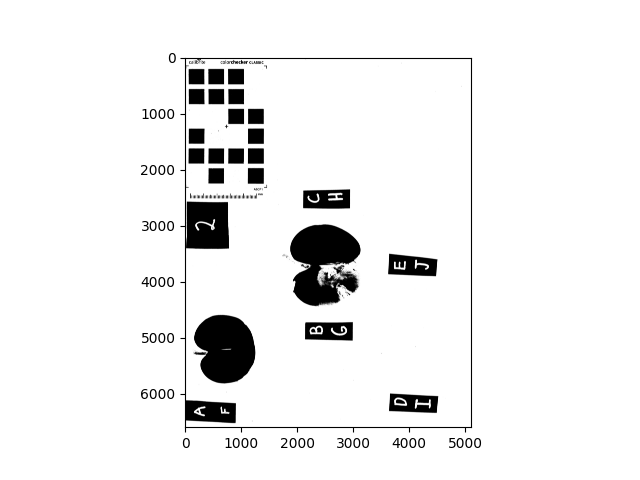

In [17]:
#_, thresh = cv.threshold(blur, 200, 255, cv.THRESH_BINARY)
_, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

thresh = cv.bitwise_not(thresh)

plt.figure()
plt.imshow(thresh, cmap="gray")

<IPython.core.display.Javascript object>


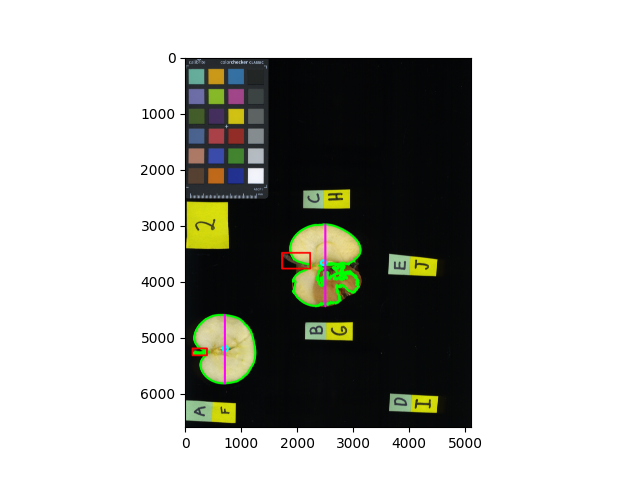

In [25]:
#Find contours
contours = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

#remove everything other than apple
filtered_contours = [cnt for cnt in contours if 650000 < cv.contourArea(cnt) < 8000000]

output_cp = im

object_info = []

#Draw apple contours
cv.drawContours(output_cp, filtered_contours, -1, (0, 255, 0), 35)

for apple_idx, contour in enumerate(filtered_contours):
    M = cv.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    cv.circle(output_cp, (cx, cy), 45, (0, 255, 255), 35) 
    
    x, y, w, h = cv.boundingRect(contour)
    #Extract section that overlaps stem
    sx0,sy0,sx1,sy1 = x, y, x+w//2, y+h
    #Find stem mask within roi
    for idx, mask in enumerate(masks):
        mask_roi = np.array(mask[sy0:sy1, sx0:sx1])
        if(np.any(mask_roi==1)): 
            stem_id = idx
         
    if stem_id is not None:
        stem_length = stem_lengths[stem_id]

        coords = boxes[stem_id]
        bx0,by0,bx1,by1 = coords
        
        #Draw bounding box for stem
        cv.rectangle(output_cp, (bx0,by0),(bx1, by1), (255,0,0), 30)
        
        pass
    
    #Draw width
    cv.line(output_cp, (x + w // 2, y), (x + w // 2, y + h), (255, 0, 255), 35)
    
    width = h    
    
    object_info.append({
    'Object_ID': apple_idx + 1,
    'apple_width': width,        # Apple width
    'stem_length': stem_length,        # Stem length
    })
    
    stem_id = None
    stem_length = None
    
     
plt.figure()
plt.imshow(output_cp)

In [10]:
pd.DataFrame(object_info)

,Object_ID,apple_width,stem_length
0,1,1224,258.0
1,2,1462,501.0
2,3,846,NaN
